In [1]:
#!pip3 install tensorflow==2.3.0
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Conv2D,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import  Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, cv2
import random
import scipy
import time
np.random.seed(0)   #Don't change this line. In each notebook, the seed is set to 0. So that same random orders are generated.

2.3.0
2.4.0


In [2]:
data_path='/content/drive/MyDrive/Colab_Dataset/org_brain_canc_data/original_data/data/train'
list_folder=os.listdir(path = data_path)
data=[]
im_size=240    
for i in list_folder:
    new_path=os.path.join(data_path,i) 
    pic_list=os.listdir(new_path)                                               
    for img in pic_list:
        pic=os.path.join(new_path,img)   
        arr=cv2.imread(pic)
        data.append([arr,list_folder.index(i)])    
        
random.Random(0).shuffle(data)  #Don't change this line. In each notebook, the seed is set to 0. So that same random orders are generated.
x_train,y_train=[],[]
for i,j in data:
    x_train.append(i)
    y_train.append(j)
x_train=np.array(x_train).reshape(-1,im_size,im_size,3)
y_train=np.array(y_train).reshape(-1,1)

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train)
X_train = x_train/255
y_train = y_train.toarray()

X_train, X_test, Y_train, Y_test = train_test_split(X_train,y_train, test_size=0.2, random_state=0)

print('Dimension of training and testing images :', X_train.shape[1:3])
print('Number of training set images : ', X_train.shape[0])
print('Number of testing set images : ', X_test.shape[0])

Dimension of training and testing images : (240, 240)
Number of training set images :  769
Number of testing set images :  193


In [3]:
train_labels = np.argmax(Y_train, axis=-1)
flair_class = 0
t1_class = 0
t1ce_class = 0 
t2_class = 0

for i in range(len(train_labels)):
  if train_labels[i] == 0:
    flair_class += 1
  elif train_labels[i] == 1:
    t1_class += 1
  elif train_labels[i] == 2:
    t1ce_class += 1
  elif train_labels[i] == 3:
    t2_class += 1


if flair_class + t1_class + t1ce_class + t2_class == X_train.shape[0]:
  print('Everything is okay.')
  print('No of flair_class in Train set: ',flair_class)
  print('No of t1_class in Train set: ',t1_class)
  print('No of t1ce_class in Train set: ',t1ce_class)
  print('No of t2_class in Train set: ',t2_class)
else:
  print("Something is wrong!")

Everything is okay.
No of flair_class in Train set:  189
No of t1_class in Train set:  206
No of t1ce_class in Train set:  184
No of t2_class in Train set:  190


In [4]:
weight_for_flair = (flair_class + t1_class + t1ce_class + t2_class)/(4.0*flair_class)
weight_for_t1 = (flair_class + t1_class + t1ce_class + t2_class)/(4*t1_class)
weight_for_t1ce = (flair_class + t1_class + t1ce_class + t2_class)/(4*t1ce_class)
weight_for_t2 = (flair_class + t1_class + t1ce_class + t2_class)/(4*t2_class)

class_weight = {0: weight_for_flair, 1: weight_for_t1, 2: weight_for_t1ce, 3: weight_for_t2}
print('Weight for class 0: {:.2f}'.format(weight_for_flair))
print('Weight for class 1: {:.2f}'.format(weight_for_t1))
print('Weight for class 2: {:.2f}'.format(weight_for_t1ce))
print('Weight for class 3: {:.2f}'.format(weight_for_t2))


Weight for class 0: 1.02
Weight for class 1: 0.93
Weight for class 2: 1.04
Weight for class 3: 1.01


In [5]:
inputs = tf.keras.Input(shape=(240,240,3))

x = Conv2D(32,(3,3), activation='relu')(inputs)
x = Conv2D(64,(3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(128, (3,3), activation = 'relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(256, (3,3), activation = 'relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(512, (3,3), activation = 'relu')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(512, (3,3), activation = 'relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(rate = 0.2)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(rate = 0.2)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(rate = 0.3)(x)
outputs = Dense(4, activation = 'softmax')(x)

classifier = Model(inputs = inputs, outputs = outputs)
opt1 = Adam(learning_rate = 1e-4)
opt2 = RMSprop(learning_rate = 1e-4)
classifier.compile(optimizer = opt2 , loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 238, 238, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 236, 236, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 118, 118, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 116, 116, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)      

In [6]:
#TRAINING MODEL
"""
import math
def scheduler(epoch, lr):
  if epoch > 20 and epoch%10==0:
    return lr * math.exp(-0.05)
  else:
    return lr

lr_reduce = LearningRateScheduler(scheduler, verbose=1)
"""
original_checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/Normal_tensorflow.h5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)


history = classifier.fit(X_train, Y_train, batch_size = 16, epochs = 100, class_weight=class_weight,
                         validation_data=(X_test, Y_test), callbacks=[original_checkpoint])



Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 1.3846 - accuracy: 0.2679
Epoch 00001: val_accuracy improved from -inf to 0.26425, saving model to /content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/Normal_tensorflow.h5
49/49 [==============================] - 6s 116ms/step - loss: 1.3846 - accuracy: 0.2679 - val_loss: 1.3585 - val_accuracy: 0.2642
Epoch 2/100
48/49 [============================>.] - ETA: 0s - loss: 1.3524 - accuracy: 0.3333
Epoch 00002: val_accuracy improved from 0.26425 to 0.36269, saving model to /content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/Normal_tensorflow.h5
49/49 [==============================] - 5s 105ms/step - loss: 1.3531 - accuracy: 0.3329 - val_loss: 1.3084 - val_accuracy: 0.3627
Epoch 3/100
48/49 [============================>.] - ETA: 0s - loss: 1.2785 - accuracy: 0.3984
Epoch 00003: val_accuracy did not improve from 0.36269
49/49 [==============================] - 5s 101ms/step - loss: 1.2789 - accuracy: 0.3979 - val_loss: 

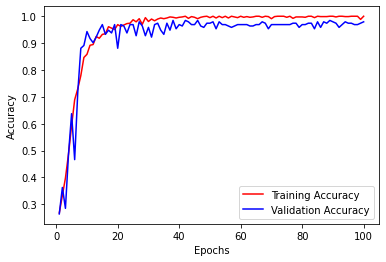

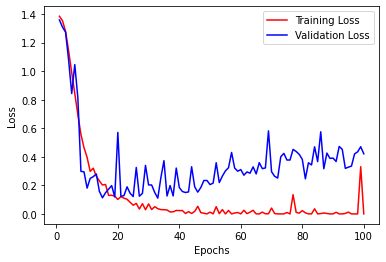

7/7 [==============================] - 0s 42ms/step - loss: 0.1260 - accuracy: 0.9845
Loss:  0.12598660588264465
Accuracy:  0.984455943107605


In [7]:
#VISUALISING THE MODEL
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, color='red', label='Training Loss')
plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

classifier = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/Normal_tensorflow.h5')
original_evaluation = classifier.evaluate(X_test, Y_test)
print('Loss: ',original_evaluation[0])
print('Accuracy: ',original_evaluation[1])

In [8]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
tflite_float_model = converter.convert()

# Show model size in MBs.
float_model_size = len(tflite_float_model) / (1024*1024)
print('Float model size = %fKBs.' % float_model_size)

#Save the TFLite Model
with open("/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/Normal_TFLite.tflite", "wb") as f:
  f.write(tflite_float_model)
print("Wrote %sTFLite model of %d bytes." , len(tflite_float_model))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpkc6xcx2x/assets
Float model size = 27.650627KBs.
Wrote %sTFLite model of %d bytes. 28993784


In [9]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / (1024*1024)
print('Quantized model size = %fMBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

#Save this Quantized TFLite Model
with open("/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/Normal_Quantized_TFLite.tflite", "wb") as f:
  f.write(tflite_quantized_model)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if tflite_quantized_model else "", len(tflite_quantized_model)))

INFO:tensorflow:Assets written to: /tmp/tmplbdviu4q/assets


INFO:tensorflow:Assets written to: /tmp/tmplbdviu4q/assets


Quantized model size = 6.926651MBs,
which is about 25% of the float model size.
Wrote optimized TFLite model of 7263120 bytes.


In [10]:
from tensorflow import keras

#Read the model in
tflite_model = '/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/Normal_TFLite.tflite'
tflite_model_quantized = '/content/drive/MyDrive/Colab_Dataset/Brain Cancer/v2/Normal_Quantized_TFLite.tflite'

# Initialize TFLite interpreter using the model.
# Load TFLite model and allocate tensors.

#normal
interpreter = tf.lite.Interpreter(model_path=tflite_model)
interpreter.allocate_tensors()
#quantized
interpreter_q = tf.lite.Interpreter(model_path=tflite_model_quantized)
interpreter_q.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_details_q = interpreter_q.get_input_details()
output_details_q = interpreter_q.get_output_details()
n = 0  #count for accuracy
q = 0
normal = []
quantized = []
# Test model on input data.
for i in range(1, len(X_test)):
  test_image = np.expand_dims(X_test[i], axis=0).astype(np.float32)
  interpreter.set_tensor(input_details[0]['index'], test_image)
  interpreter_q.set_tensor(input_details_q[0]['index'], test_image)
  interpreter.invoke()
  interpreter_q.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  output_data = interpreter.get_tensor(output_details[0]['index'])
  output_data_q = interpreter_q.get_tensor(output_details_q[0]['index'])

  if np.argmax(output_data)==np.argmax(Y_test[i]):
    n+=1
  else:
    normal.append(i)

  if np.argmax(output_data_q)==np.argmax(Y_test[i]):
    q+=1
  else:
    quantized.append(i)
print('\n\nAccuracy of normal model= ', n/len(X_test))
print('\n\nAccuracy of quantized model= ', q/len(X_test))



Accuracy of normal model=  0.9792746113989638


Accuracy of quantized model=  0.9792746113989638


In [11]:
print('Wrongly classified images of normal model :', normal)
print('Wrongly classified images of quantized model :', quantized)

Wrongly classified images of normal model : [94, 139, 156]
Wrongly classified images of quantized model : [94, 139, 156]
